# 0. Import

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Loading

In [ ]:
FILE_PATH = '/content/drive/My Drive/졸업프로젝트/TestDataset/'
OUTPUT_DIR = Path(FILE_PATH) / "Processed_Clinical_Data"

OUTPUT_RAW_TRAIN_NPZ = 'tree_raw_train_data.npz'
OUTPUT_RAW_TEST_NPZ = 'tree_raw_test_data.npz'

In [ ]:
try:
    # train set loading
    train_data = np.load(OUTPUT_DIR / OUTPUT_RAW_TRAIN_NPZ)
    X_train_raw = train_data['X_train']
    Y_train_raw = train_data['Y_train']

    # test set loading
    test_data = np.load(OUTPUT_DIR / OUTPUT_RAW_TEST_NPZ)
    X_test_raw = test_data['X_test']
    Y_test_raw = test_data['Y_test']

except FileNotFoundError:
    print("[Error] Raw data NPZ files not found. Please run clinical_data_prep_split_fixed.py first.")
    exit()

print(f"Train/Test set loaded successfully.")
print(f"Train set shape: {X_train_raw.shape}, Test set shape: {X_test_raw.shape}")

Train/Test set loaded successfully.
Train set shape: (160080, 37), Test set shape: (40020, 37)


# 2. Evaluation Function

In [ ]:
def evaluate_models_and_plot(y_test, xgb_prob_all, rf_prob_all, n_classes, threshold=0.5):
    def get_metrics(prob_all, threshold):
        if n_classes == 2:
            prob = prob_all[:, 1]
            pred = (prob >= threshold).astype(int)
            roc_auc = roc_auc_score(y_test, prob)
            pr_auc = average_precision_score(y_test, prob)
            cm = confusion_matrix(y_test, pred)
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            pred = np.argmax(prob_all, axis=1)
            roc_auc = roc_auc_score(y_test, prob_all, multi_class='ovr', average='macro')
            pr_auc = average_precision_score(y_test, prob_all, average='macro')
            cm = confusion_matrix(y_test, pred)
            spec = 0.0

        avg_type = 'binary' if n_classes == 2 else 'macro'
        return {
            "Accuracy": accuracy_score(y_test, pred),
            "Recall": recall_score(y_test, pred, average=avg_type, zero_division=0),
            "Precision": precision_score(y_test, pred, average=avg_type, zero_division=0),
            "F1": f1_score(y_test, pred, average=avg_type, zero_division=0),
            "ROC_AUC": roc_auc,
            "PR_AUC": pr_auc,
            "Specificity": spec,
            "Confusion_Matrix": cm
        }


    res_xgb = get_metrics(xgb_prob_all, threshold)
    res_rf = get_metrics(rf_prob_all, threshold)

    plt.style.use('seaborn-v0_8-muted')
    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.heatmap(res_xgb["Confusion_Matrix"], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'XGBoost Confusion Matrix (Th:{threshold})')

    sns.heatmap(res_rf["Confusion_Matrix"], annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'Random Forest Confusion Matrix (Th:{threshold})')
    plt.tight_layout()
    plt.show()

    metrics_list = ["Accuracy", "Recall", "Precision", "F1", "ROC_AUC", "PR_AUC", "Specificity"]
    df_viz = pd.DataFrame({
        'Metric': metrics_list * 2,
        'Score': [res_xgb[m] for m in metrics_list] + [res_rf[m] for m in metrics_list],
        'Model': ['XGBoost'] * len(metrics_list) + ['Random Forest'] * len(metrics_list)
    })

    # 각 모델 성능 지표 막대그래프
    g = sns.FacetGrid(df_viz, col="Model", hue="Model", palette=["#3498db", "#2ecc71"], height=5, aspect=1.2)
    g.map(sns.barplot, "Metric", "Score", order=metrics_list)
    g.set_xticklabels(rotation=45)
    g.set_titles("{col_name} Performance")
    for ax in g.axes.flat:
        ax.set_ylim(0, 1.1)
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, xytext=(0, 7), textcoords='offset points')
    plt.tight_layout()
    plt.show()

    # 두 모델 비교 그래프
    plt.figure(figsize=(12, 6))
    compare_plot = sns.barplot(data=df_viz, x='Metric', y='Score', hue='Model', palette="viridis")
    plt.title(f'Model Performance Comparison (Threshold: {threshold})', fontsize=15)
    plt.ylim(0, 1.2)
    plt.xticks(rotation=45)
    for p in compare_plot.patches:
        compare_plot.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center', fontsize=9, xytext=(0, 7), textcoords='offset points')
    plt.tight_layout()
    plt.show()

    return res_xgb, res_rf

# 3. Training

In [ ]:
ratio = float(np.sum(Y_train_raw == 0)) / np.sum(Y_train_raw == 1)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    scale_pos_weight=ratio # 클래스 불균형 해결
)
xgb.fit(X_train_raw, Y_train_raw)

xgb_pred = xgb.predict(X_test_raw)
xgb_prob_all = xgb.predict_proba(X_test_raw)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight={0: 1, 1: 4}, # 클래스 불균형 해결
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_raw, Y_train_raw)

rf_pred = rf.predict(X_test_raw)
rf_prob_all = rf.predict_proba(X_test_raw)

# 4. Evaluation


 ===== Evaluation at threshold 0.1 =====


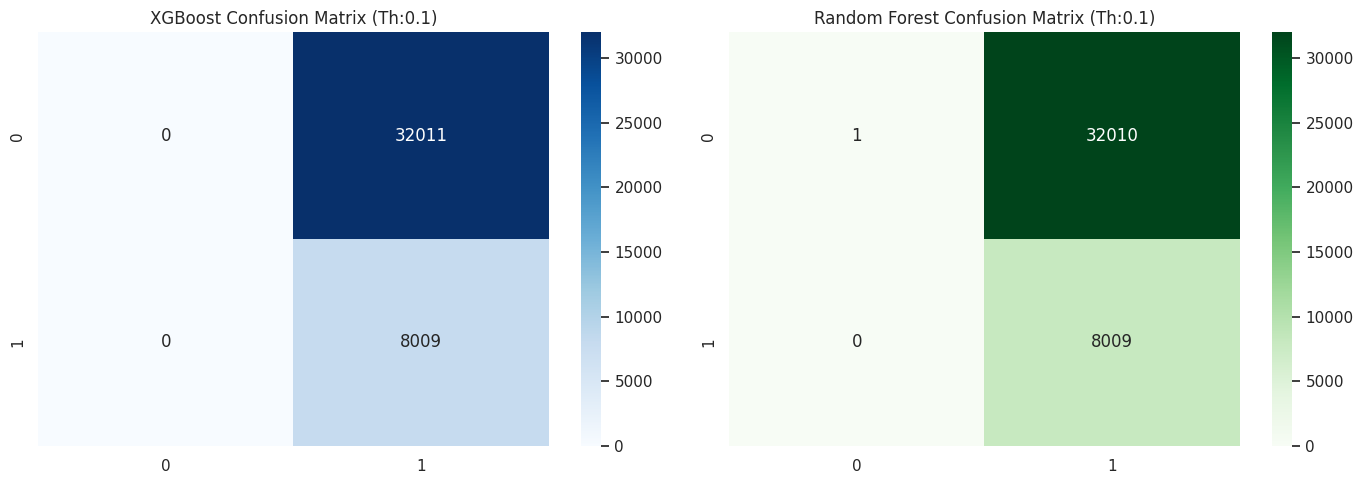

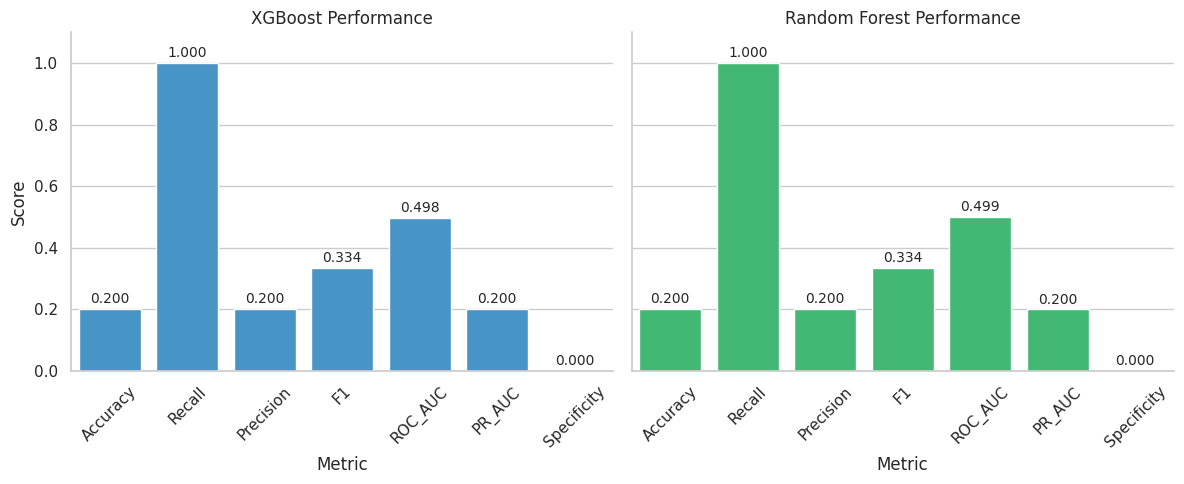

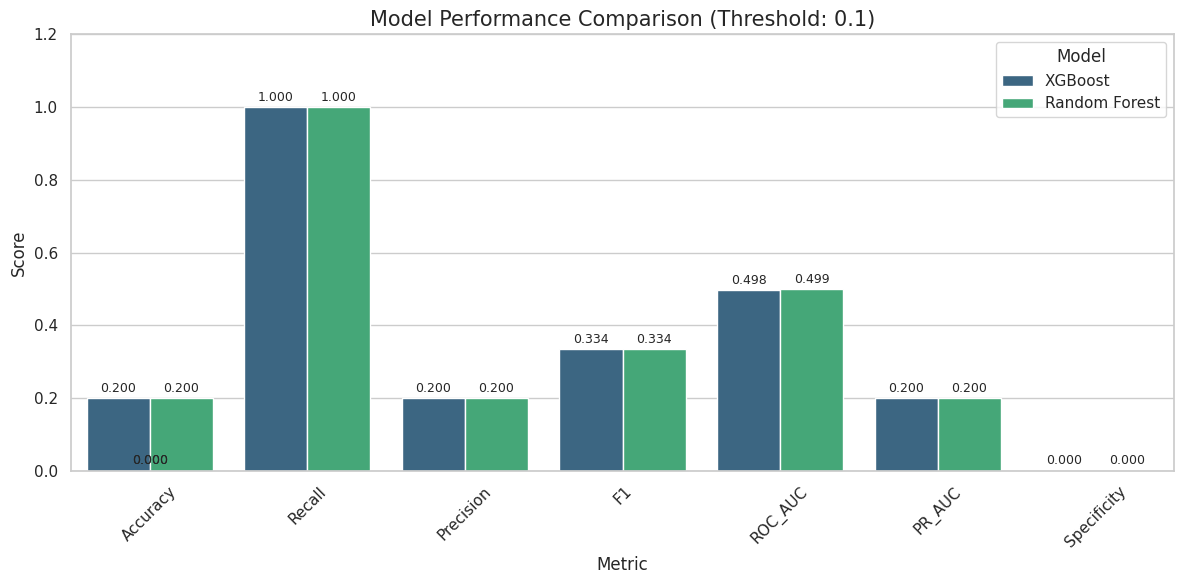

{'Accuracy': 0.2001249375312344, 'Recall': 1.0, 'Precision': 0.2001249375312344, 'F1': 0.333506839617731, 'ROC_AUC': np.float64(0.4975268209381718), 'PR_AUC': np.float64(0.20032036931419644), 'Specificity': np.float64(0.0), 'Confusion_Matrix': array([[    0, 32011],
       [    0,  8009]])}
{'Accuracy': 0.20014992503748125, 'Recall': 1.0, 'Precision': 0.20012993827931733, 'F1': 0.33351378362621803, 'ROC_AUC': np.float64(0.49897610775332063), 'PR_AUC': np.float64(0.19957436556515545), 'Specificity': np.float64(3.123926150385805e-05), 'Confusion_Matrix': array([[    1, 32010],
       [    0,  8009]])}

 ===== Evaluation at threshold 0.2 =====


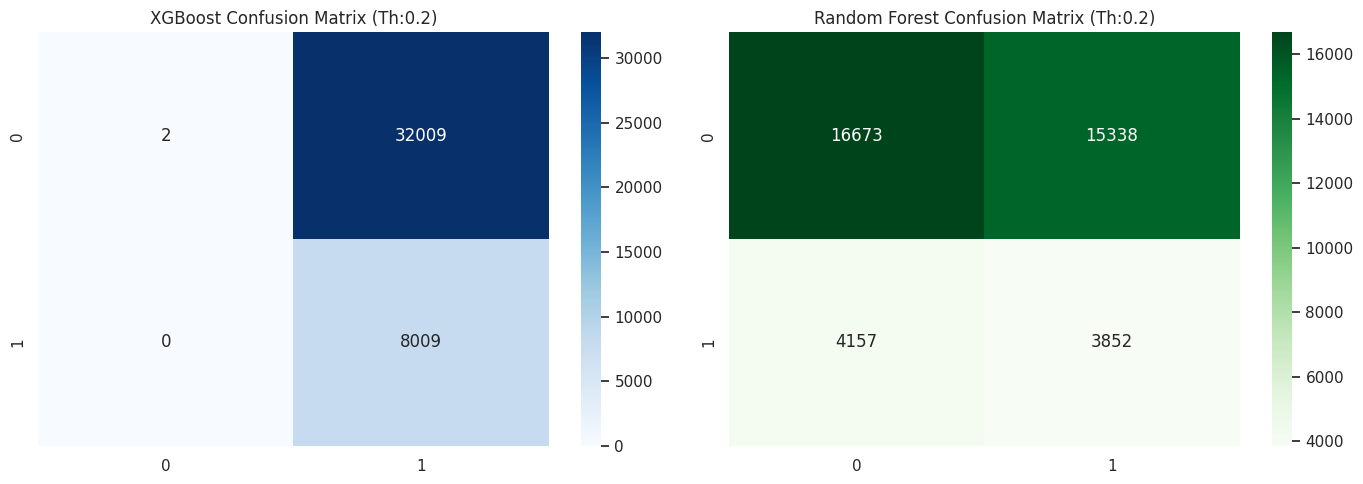

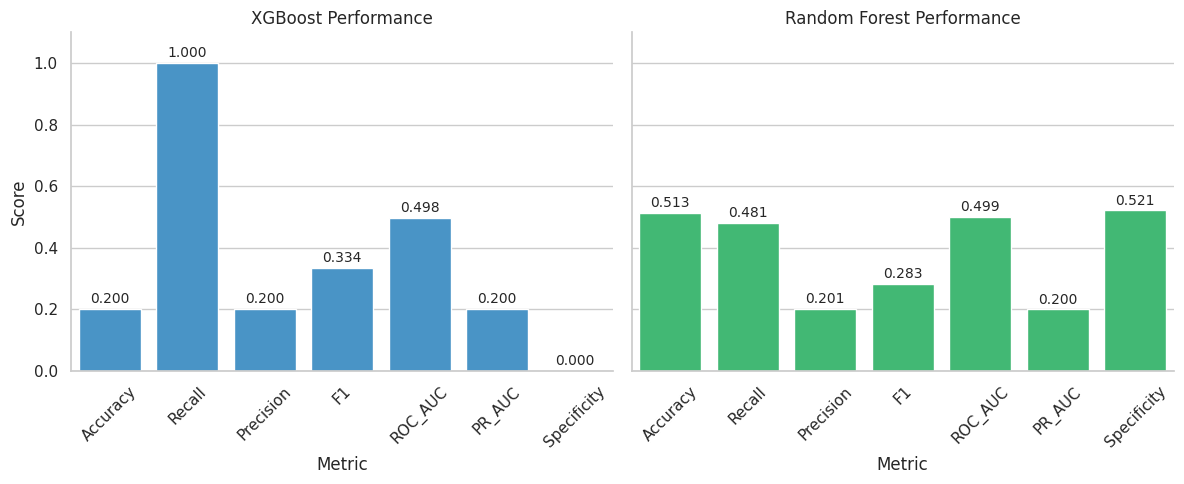

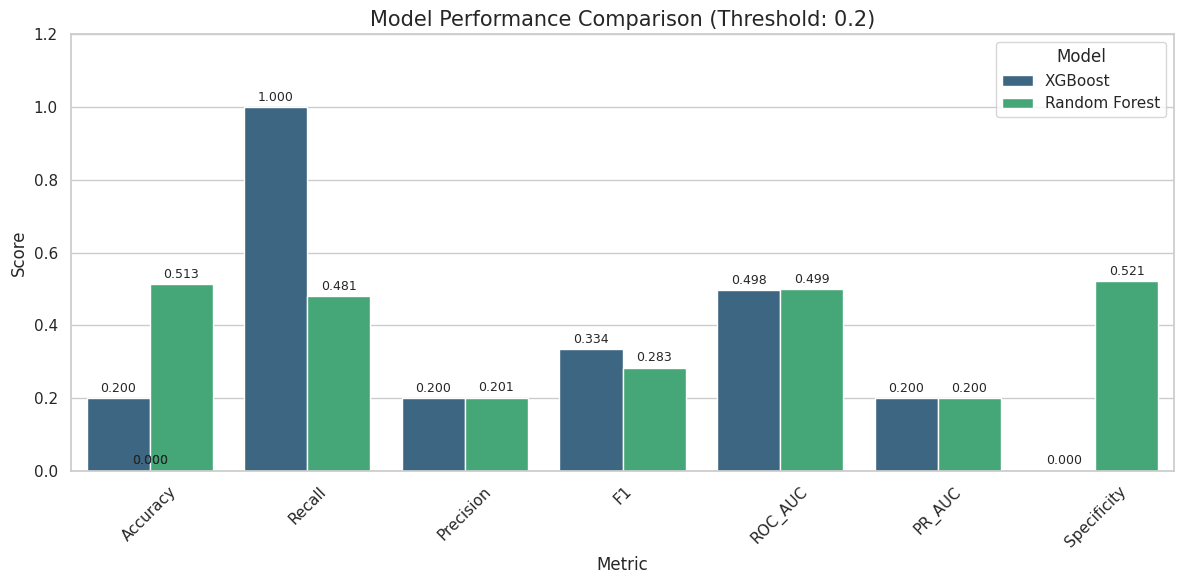

{'Accuracy': 0.20017491254372813, 'Recall': 1.0, 'Precision': 0.2001349392773252, 'F1': 0.33352072792387616, 'ROC_AUC': np.float64(0.4975268209381718), 'PR_AUC': np.float64(0.20032036931419644), 'Specificity': np.float64(6.24785230077161e-05), 'Confusion_Matrix': array([[    2, 32009],
       [    0,  8009]])}
{'Accuracy': 0.5128685657171415, 'Recall': 0.48095892121363465, 'Precision': 0.2007295466388744, 'F1': 0.28324570756277806, 'ROC_AUC': np.float64(0.49897610775332063), 'PR_AUC': np.float64(0.19957436556515545), 'Specificity': np.float64(0.5208522070538253), 'Confusion_Matrix': array([[16673, 15338],
       [ 4157,  3852]])}

 ===== Evaluation at threshold 0.3 =====


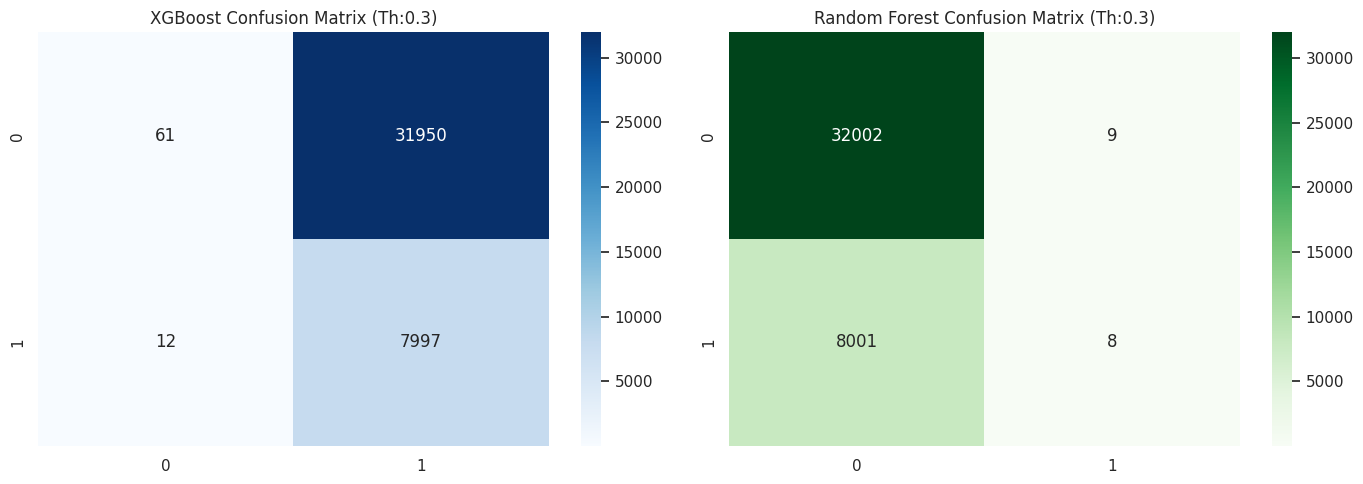

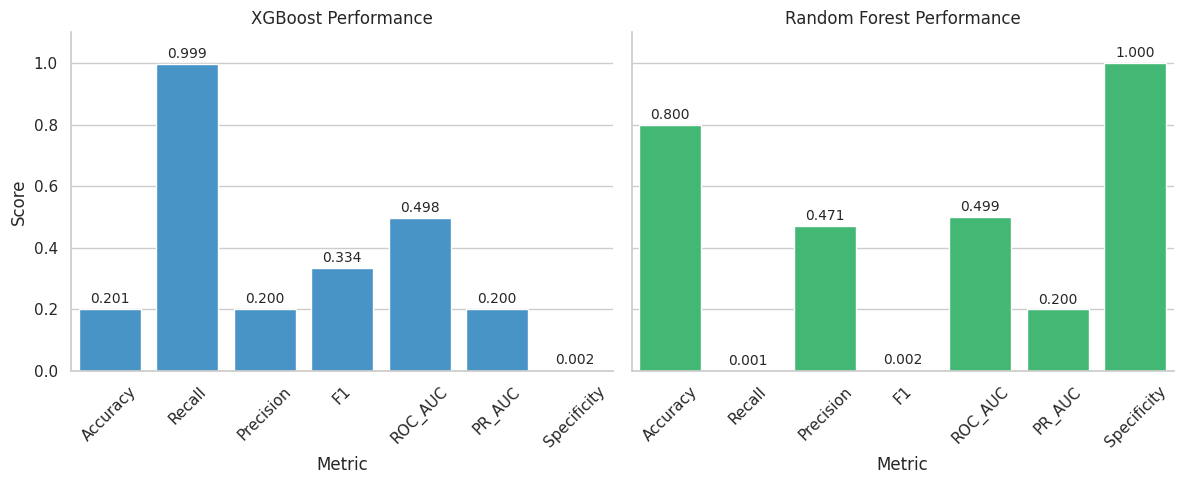

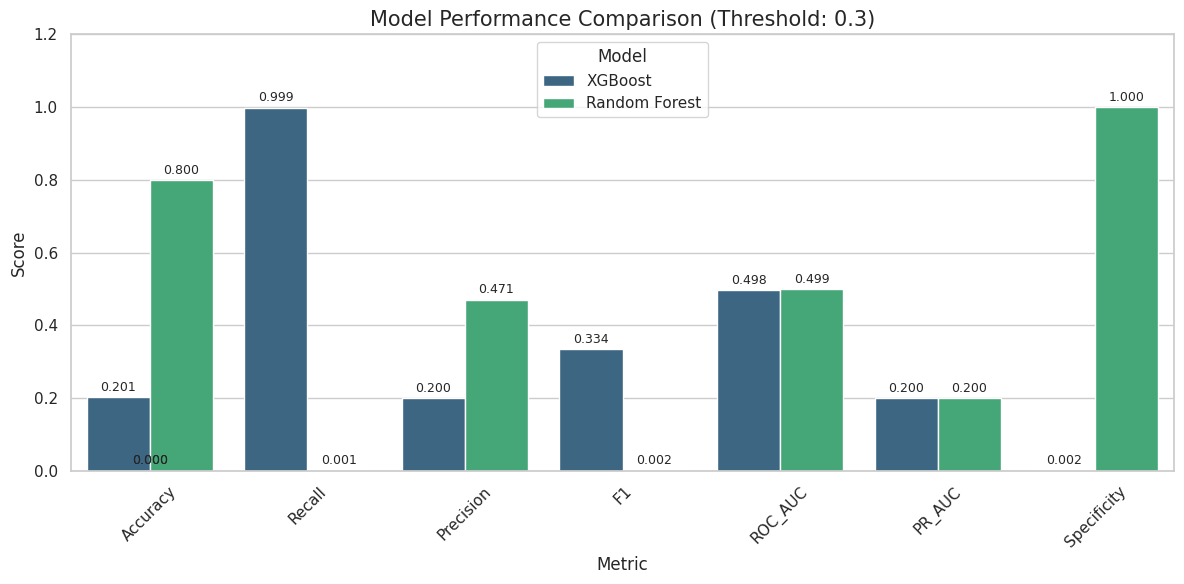

{'Accuracy': 0.20134932533733133, 'Recall': 0.9985016856036958, 'Precision': 0.2001902520840113, 'F1': 0.33351405455000416, 'ROC_AUC': np.float64(0.4975268209381718), 'PR_AUC': np.float64(0.20032036931419644), 'Specificity': np.float64(0.001905594951735341), 'Confusion_Matrix': array([[   61, 31950],
       [   12,  7997]])}
{'Accuracy': 0.7998500749625187, 'Recall': 0.000998876264202772, 'Precision': 0.47058823529411764, 'F1': 0.00199352105656616, 'ROC_AUC': np.float64(0.49897610775332063), 'PR_AUC': np.float64(0.19957436556515545), 'Specificity': np.float64(0.9997188466464653), 'Confusion_Matrix': array([[32002,     9],
       [ 8001,     8]])}

 ===== Evaluation at threshold 0.4 =====


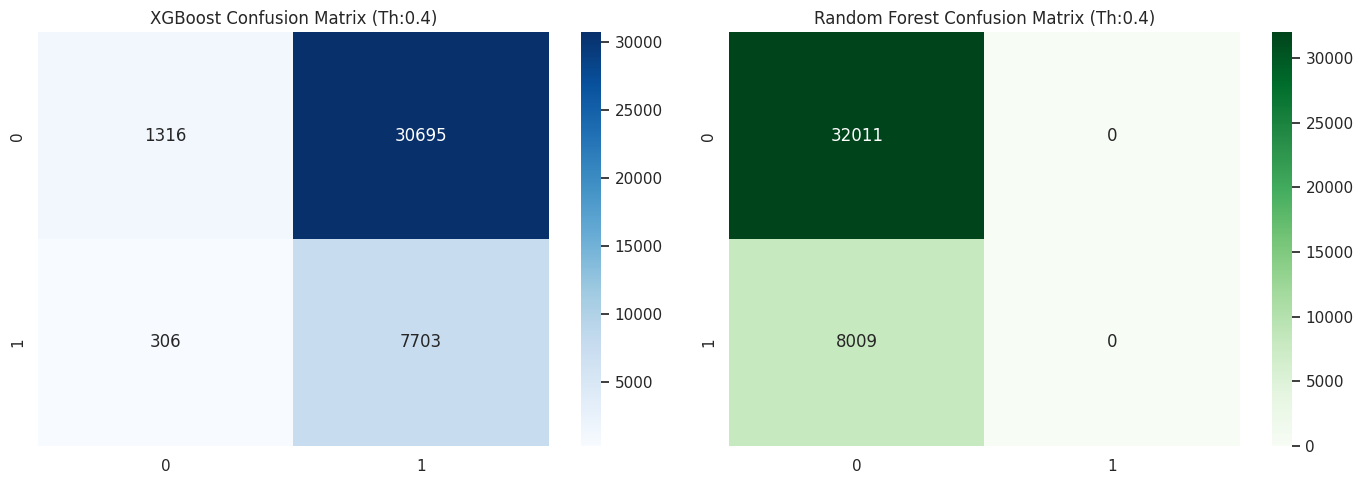

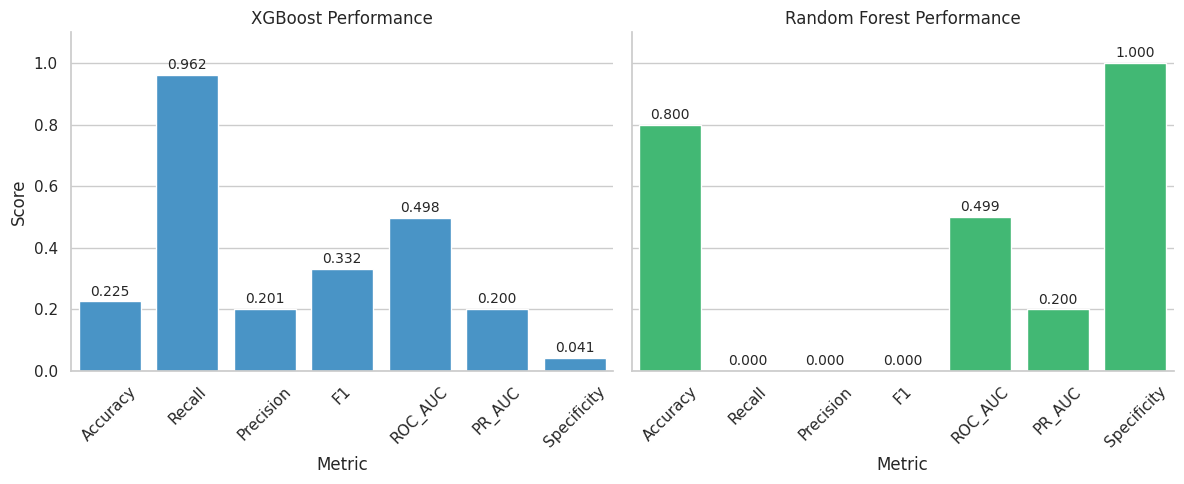

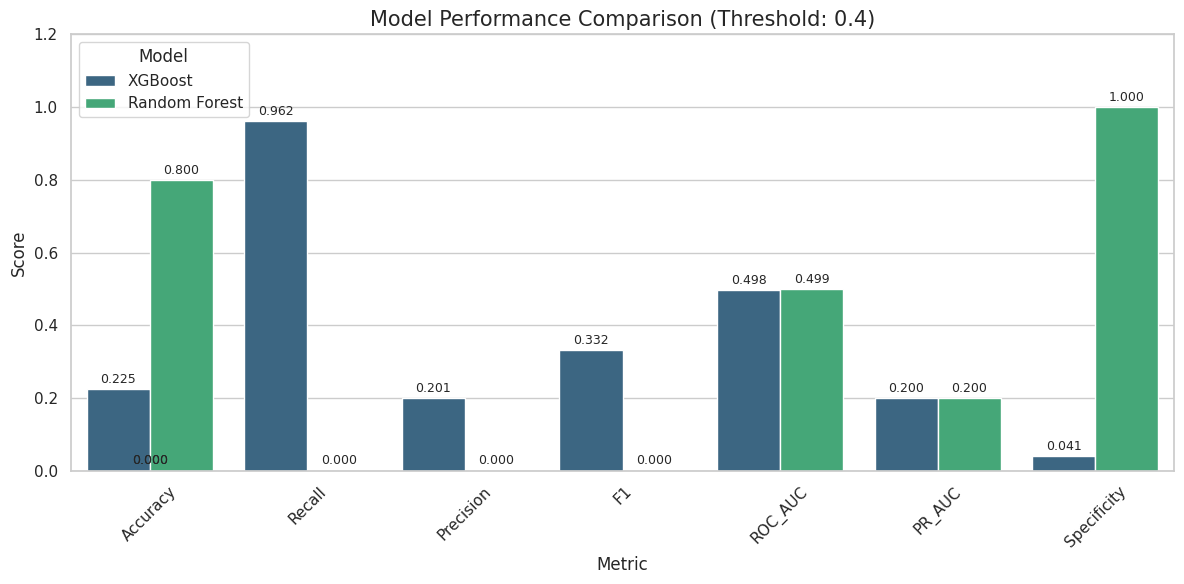

{'Accuracy': 0.22536231884057972, 'Recall': 0.961792982894244, 'Precision': 0.20060940673993438, 'F1': 0.3319757795160213, 'ROC_AUC': np.float64(0.4975268209381718), 'PR_AUC': np.float64(0.20032036931419644), 'Specificity': np.float64(0.04111086813907719), 'Confusion_Matrix': array([[ 1316, 30695],
       [  306,  7703]])}
{'Accuracy': 0.7998750624687656, 'Recall': 0.0, 'Precision': 0.0, 'F1': 0.0, 'ROC_AUC': np.float64(0.49897610775332063), 'PR_AUC': np.float64(0.19957436556515545), 'Specificity': np.float64(1.0), 'Confusion_Matrix': array([[32011,     0],
       [ 8009,     0]])}

 ===== Evaluation at threshold 0.5 =====


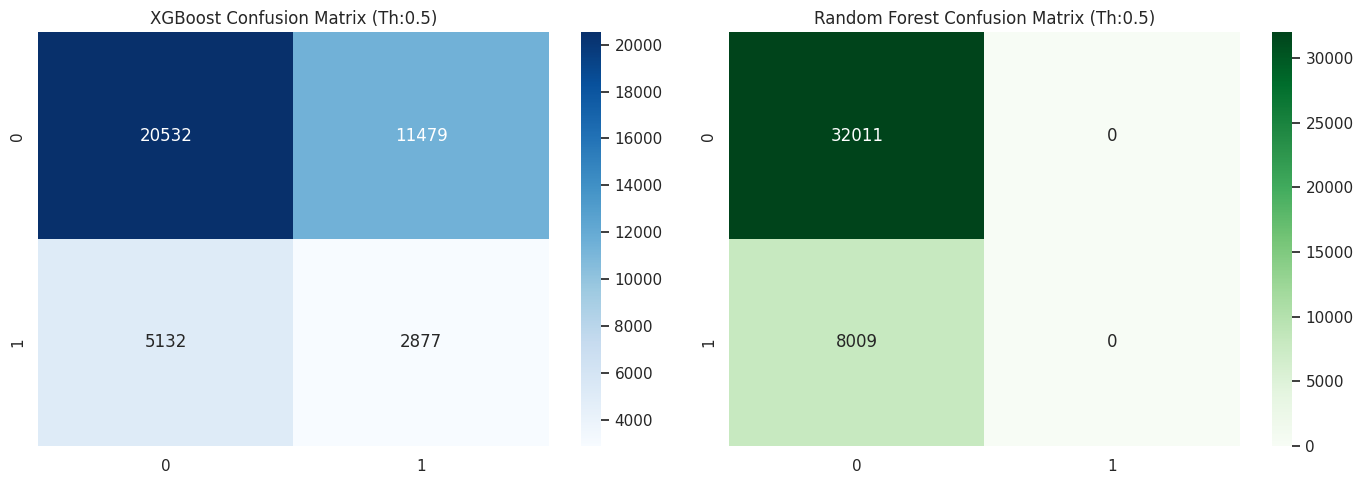

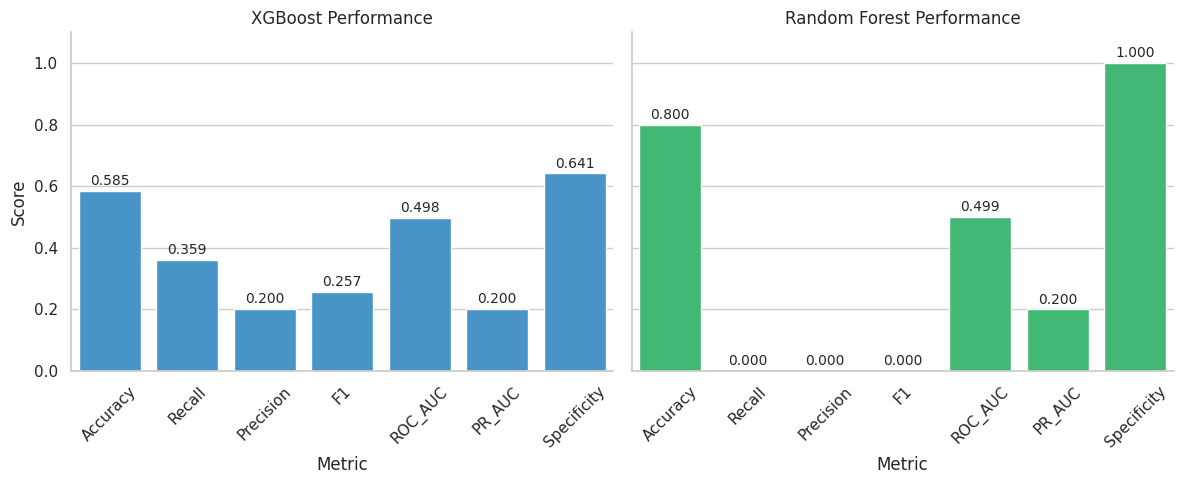

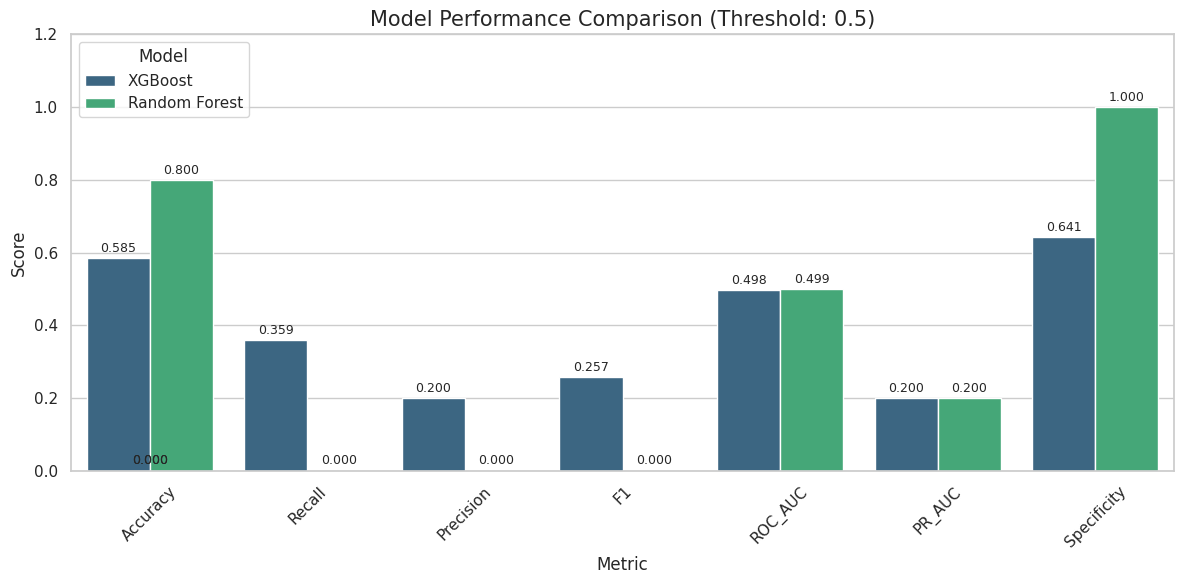

{'Accuracy': 0.5849325337331335, 'Recall': 0.3592208765139218, 'Precision': 0.20040401225968235, 'F1': 0.25727699530516435, 'ROC_AUC': np.float64(0.4975268209381718), 'PR_AUC': np.float64(0.20032036931419644), 'Specificity': np.float64(0.6414045171972135), 'Confusion_Matrix': array([[20532, 11479],
       [ 5132,  2877]])}
{'Accuracy': 0.7998750624687656, 'Recall': 0.0, 'Precision': 0.0, 'F1': 0.0, 'ROC_AUC': np.float64(0.49897610775332063), 'PR_AUC': np.float64(0.19957436556515545), 'Specificity': np.float64(1.0), 'Confusion_Matrix': array([[32011,     0],
       [ 8009,     0]])}


In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for t in thresholds:
    print(f"\n ===== Evaluation at threshold {t} =====")
    results_xgb, results_rf = evaluate_models_and_plot(
        Y_test_raw,
        xgb_prob_all,
        rf_prob_all,
        n_classes=2,
        threshold=t
    )
    print(results_xgb)
    print(results_rf)